## softmax回归的从零开始实现

- 就像我们从零开始实现线性回归一样，)我们认为softmax回归也是重要的基础，因此应该知道实现softmax回归的细节

In [1]:
# 导入工具包
import torch
from IPython import display
from d2l import torch as d2l

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size) # 直接读入数据

### 初始化模型参数

#### 将展平每个图像，把它们看作长度为784的向量

- 原始数据集中的每个样本都是 28×28的图像。 但softmax接收向量

- 回想一下，在softmax回归中，我们的输出与类别一样多。 
- 因为我们的数据集有10个类别，所以网络输出维度为10。 

- 因此，权重将构成一个 784×10的矩阵， 偏置将构成一个 1×10的行向量。 与线性回归一样，我们将使用正态分布初始化我们的权重W，偏置初始化为0。

In [6]:
num_inputs = 784  # 28x28
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

W, b

(tensor([[-0.0058, -0.0054, -0.0215,  ..., -0.0094, -0.0062,  0.0029],
         [-0.0069,  0.0016,  0.0258,  ..., -0.0110,  0.0020, -0.0021],
         [-0.0044,  0.0020,  0.0181,  ..., -0.0086,  0.0019, -0.0061],
         ...,
         [-0.0297, -0.0078, -0.0003,  ...,  0.0046,  0.0160, -0.0053],
         [ 0.0042, -0.0212, -0.0093,  ...,  0.0106,  0.0013,  0.0028],
         [ 0.0008, -0.0003, -0.0041,  ...,  0.0047, -0.0154, -0.0052]],
        requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

### 定义softmax操作

- 在实现softmax回归模型之前，简要回顾一下sum运算符如何沿着张量中的特定维度工作。
- 给定一个矩阵X，我们可以对所有元素求和
- 也可以只求同一个轴上的元素，即同一列（轴0）或同一行（轴1）

In [7]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

- $softmax(𝐗)_{𝑖𝑗} = \frac{exp(𝐗_{𝑖𝑗})}{∑_𝑘exp(𝐗_{𝑖𝑘})}$

- 回想一下，**实现softmax** 由三个步骤组成：

- 对每个项求幂（使用exp）；
- 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
- 将每一行除以其规范化常数，确保结果的和为1。

In [10]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)  # 对每一行求和
    return X_exp / partition  # 应用广播机制，把每个元素/每行partition

- 正如上述代码，对于任何随机输入，**我们将每个元素变成一个非负数。 此外，依据概率原理，每行总和为1**

In [11]:
X = torch.normal(0, 1, (2, 5))  # 2x5矩阵
X_prob = softmax(X)  # 矩阵形状不变
X_prob, X_prob.sum(1) # 每行和为1

(tensor([[0.1623, 0.1354, 0.1076, 0.4764, 0.1184],
         [0.0355, 0.1088, 0.3230, 0.0294, 0.5033]]),
 tensor([1., 1.]))

### 定义模型

- 定义softmax操作后，可以 **实现softmax回归模型**

- 下面的代码定义了输入如何通过网络映射到输出。 
- 注意，将数据传递到模型之前，我们使用reshape函数将每张原始图像展平为向量。

In [26]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)  # X 变成 256x784 矩阵

### 定义损失函数

- 接下来，实现softmax中引入的交叉熵损失函数。 这可能是深度学习中最常见的损失函数，因为目前分类问题的数量远远超过回归问题的数量。

- 回顾一下，交叉熵采用真实标签的预测概率的负对数似然。 
- 这里我们不使用Python的for循环迭代预测（这往往是低效的）， 而是通过一个运算符选择所有元素。 

- **创建一个数据样本 y_hat，其中包含2个样本在3个类别的预测概率， 以及它们对应的标签y** 

In [14]:
y = torch.tensor([0, 2]) # 0， 2 表示两个真实的标号
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])  # 两个样本
y_hat[[0, 1], y]  # 对两个样本，拿出对应标号的元素 1号(0)样本拿第0个，2号(1)样本拿第2个

tensor([0.1000, 0.5000])

#### 实现交叉熵损失函数

In [15]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y]) # 

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [19]:
torch.log(y_hat[range(len(y_hat)), y]) 

tensor([-2.3026, -0.6931])

### 分类精度

- 给定预测概率分布y_hat，当我们必须输出硬预测（hard prediction）时， 我们通常选择预测概率最高的类。 

- 当预测与标签分类y一致时，即是正确的。 分类精度即正确预测数量与总预测数量之比。 虽然直接优化精度可能很困难（因为精度的计算不可导）， 但精度通常是我们最关心的性能衡量标准，我们在训练分类器时几乎总会关注它。

#### 将预测类别与真实y元素进行比较

- 为了计算精度，我们执行以下操作。 首先，如果y_hat是矩阵，那么假定第二个维度存储每个类的预测分数。 我们使用argmax获得每行中最大元素的索引来获得预测类别。 然后我们将预测类别与真实y元素进行比较。
- 由于等式运算符“==”对数据类型很敏感， 因此我们将y_hat的数据类型转换为与y的数据类型一致。 结果是一个包含0（错）和1（对）的张量。 最后，我们求和会得到正确预测的数量。

In [20]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:  # 如果y_hat是二维矩阵 即 .shape>1 而且 列数也 > 1
        y_hat = y_hat.argmax(axis=1)                 # 每一行元素中最大值元素的下标存入 y_hat  作为 预测分类的类别
    cmp = y_hat.type(y.dtype) == y                   # 将y_hat的数据类型转换为与y的数据类型一致
    return float(cmp.type(y.dtype).sum())            # 转成跟y一样 然后求和 最后转成浮点数

accuracy(y_hat, y) / len(y)                          #

0.5

### 我们可以评估在任意模型net的精度

In [21]:
def evaluate_accuracy(net, data_iter): 
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()                          # 将模型设置为评估模式,不计算梯度
    metric = Accumulator(2)                 # 正确预测数、预测总数  accumulator 累加器
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

#### Accumulator实例中创建了2个变量， 分别用于存储正确预测的数量和预测的总数量

In [22]:
class Accumulator: 
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n  # 初始化，根据传进来的n的大小来创建n个空间，且全部初始化为0.0
    
    """
    使用.add()的时候，虽然*args代表这里可以传入任意个参数，但是因为要和初始化的个数相同不然要报错
    
    zip() 函数创建了一个迭代器，它将聚合来自两个或多个可迭代对象的元素
    
    for a,b in zip(self.data,args)是把原来类中对应位置的 data 和新传入的 args 做 a + float(b)
    然后重新赋给该位置的data
    
    这样整体起到累加效果
    """
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)] 

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [27]:
evaluate_accuracy(net, test_iter) # 由于我们使用随机权重初始化net模型， 因此该模型的精度应接近于随机猜测

0.0828

### 训练

#### softmax回归的训练。

- 在这里，我们重构训练过程的实现以使其可重复使用。 
- 首先，我们定义一个函数来训练一个迭代周期

In [28]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式 - 计算梯度
    if isinstance(net, torch.nn.Module): # 两种情况都考虑到，保证重用
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()  # 梯度置零
            l.mean().backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

#### 定义一个在动画中绘制数据的实用程序类 Animator

- 以便实时观看训练中的过程

In [29]:
class Animator: 
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

### 训练函数

In [30]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):  # 周期迭代
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)  # 测试集评估精度
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

#### 小批量随机梯度下降来优化模型的损失函数

In [31]:
lr = 0.1  # 学习率

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

#### 训练模型10个迭代周期

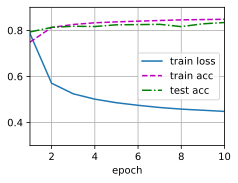

In [32]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 预测

#### 对图像进行分类预测

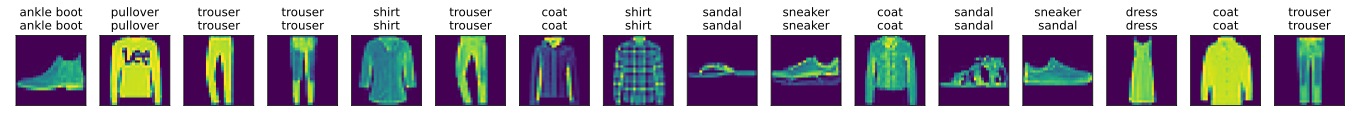

In [34]:
def predict_ch3(net, test_iter, n=16): 
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)